In [ ]:
pip install wordsegment

     |████████████████████████████████| 4.8MB 8.2MB/s 


In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.probability import FreqDist
import re
import inflect
from wordsegment import load, segment
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import os
os.chdir('C:/Users/Sebastian/Desktop/ORIE 4741 Big Messy Data/Project/COVID Twitter/')

In [ ]:
# import training set and test set
# encoding latin1 o.w. unicode decode error
train_set = pd.read_csv('Corona_NLP_train.csv', encoding='latin1')
test_set = pd.read_csv('Corona_NLP_test.csv', encoding='latin1')

# drop duplicates from dataframe
train_set.drop_duplicates(keep=False,inplace=True) 
test_set.drop_duplicates(keep=False,inplace=True) 

train_set.info()

# % of missing values per column
train_set.isnull().sum()/len(train_set)*100
test_set.isnull().sum()/len(train_set)*100

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


UserName         0.000000
ScreenName       0.000000
Location         2.026387
TweetAt          0.000000
OriginalTweet    0.000000
Sentiment        0.000000
dtype: float64

In [ ]:
train_set['Sentiment'].value_counts(normalize=True) * 100

Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: Sentiment, dtype: float64

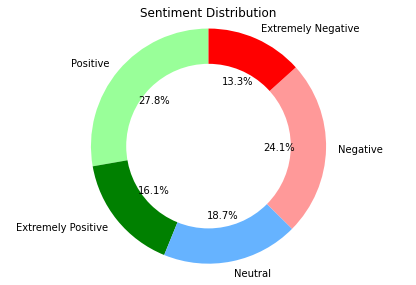

In [ ]:
import matplotlib.pyplot as plt
labels = ['Positive', 'Extremely Positive', 'Neutral', 'Negative', 'Extremely Negative']
sizes = [27.752266, 16.094468, 18.740433, 24.095537, 13.317297]
colors = ['#99ff99','green','#66b3ff','#ff9999', 'red']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
ax1.title.set_text('Sentiment Distribution')
plt.tight_layout()
plt.savefig('sentiment.png')
plt.show()

In [ ]:
import re
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there has",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you would",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_re.sub(replace, s)

In [ ]:
# preprocessing 'OriginalTweet' column
stops = set(stopwords.words("english"))

def replace_numbers(words):
    p = inflect.engine()
    text = []
    for word in words:
        if word.isdigit():
            new = p.number_to_words(word)
            text.append(new)
        else:
            text.append(word)
    return text

def preprocess(x):
  # remove urls  
  x = re.sub(r'[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x, flags=re.MULTILINE)
  # remove https
  x = re.sub(r'https?://\S+', '', x)
  x = re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE)
  # remove noise
  x = re.sub('[^a-z\s]', '', x.lower()) 
  # remove punctuations
  x = re.sub(r'[^\w\s]', '', x)
  # remove hashtags, mentions, emojis, and punctuations
  x = x.replace("#", "").replace("_", " ").replace("@", " ")
  #x = ''.join(re.sub("(@[A-Za-z0–9]+)|([⁰-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
  # segmentation
  #load()
  #x = ' '.join(segment(x))
  # spelling errors
  #x = ' '.join([Speller(w) for w in x.split()])
  # contractions
  x = expand_contractions(x)
  # remove stopwords              
  x = [w for w in x.split() if w not in stops] 
  # replace numbers with textual representations
  x = replace_numbers(x)
  return ' '.join(x)                                   

In [ ]:
train_set['CleanTweet'] = train_set['OriginalTweet'].apply(preprocess) 
test_set['CleanTweet'] = train_set['OriginalTweet'].apply(preprocess) 
train_set['CleanTweet']

0                              menyrbie philgahan chrisitv
1        advice talk neighbours family exchange phone n...
2        coronavirus australia woolworths give elderly ...
3        food stock one empty please dont panic enough ...
4        ready go supermarket covid outbreak im paranoi...
                               ...                        
41152    airline pilots offering stock supermarket shel...
41153    response complaint provided citing covid relat...
41154    know getting tough kameronwilds rationing toil...
41155    wrong smell hand sanitizer starting turn coron...
41156    tartiicat well newused rift going amazon rn al...
Name: CleanTweet, Length: 41157, dtype: object

In [ ]:
# most common words
most_common = Counter(" ".join(train_set["CleanTweet"]).split()).most_common(20)
#plt.bar(most_common.keys(), most_common.values())
word, freq = zip(*most_common)
print(word)

('covid', 'coronavirus', 'prices', 'food', 'supermarket', 'store', 'grocery', 'people', 'amp', 'consumer', 'shopping', 'online', 'pandemic', 'get', 'need', 'us', 'workers', 'panic', 'sanitizer', 'like')


No handles with labels found to put in legend.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


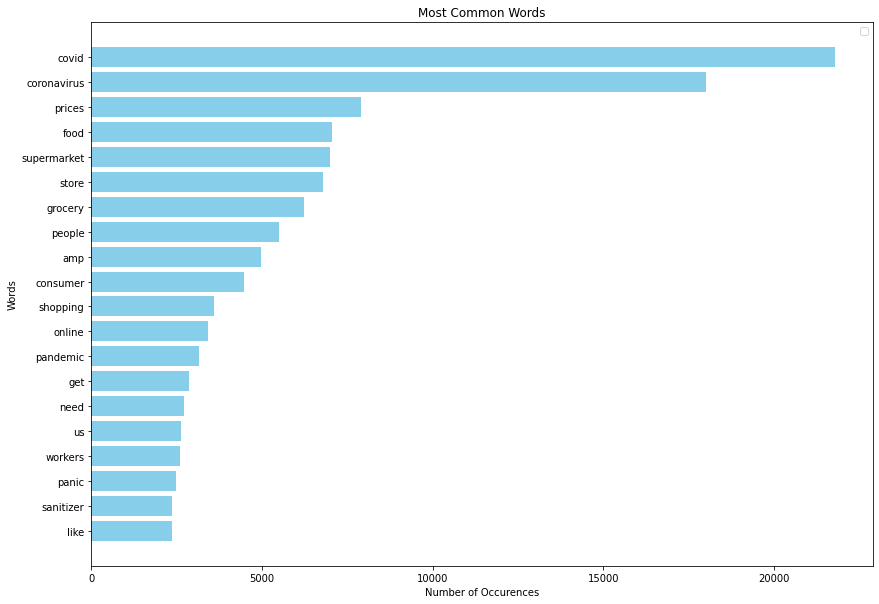

In [ ]:
import matplotlib.font_manager
hfont = {'fontname':'Helvetica'}
plt.figure(figsize=[14, 10])
plt.barh(word, freq, color = 'skyblue')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Number of Occurences', **hfont)
plt.ylabel('Words', **hfont)
plt.title('Most Common Words', **hfont)
plt.savefig('most_freq.png')
plt.show()

In [ ]:
# Ngrams (bigram and trigram)
train_set['bigrams'] = train_set['CleanTweet'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
train_set['trigrams'] = train_set['CleanTweet'].apply(lambda row: list(nltk.trigrams(row.split(' '))))
train_set['bigrams']

df = train_set.groupby('Sentiment').agg({'bigrams': 'sum'})

# Compute the most frequent bigrams by category
from collections import Counter
bigram = df.bigrams.apply(lambda row: Counter(row)).to_frame()

In [ ]:
bigram.bigrams.apply(lambda row: list(row)[0:10])

Sentiment
Extremely Negative    [(ready, go), (go, supermarket), (supermarket,...
Extremely Positive    [(due, covid), (covid, situation), (situation,...
Negative              [(corona, preventionwe), (preventionwe, stop),...
Neutral               [(menyrbie, philgahan), (philgahan, chrisitv),...
Positive              [(advice, talk), (talk, neighbours), (neighbou...
Name: bigrams, dtype: object

No handles with labels found to put in legend.


['grocery store', 'coronavirus covid', 'covid coronavirus', 'hand sanitizer', 'online shopping', 'toilet paper', 'covid pandemic', 'panic buying', 'oil prices', 'covid covid']


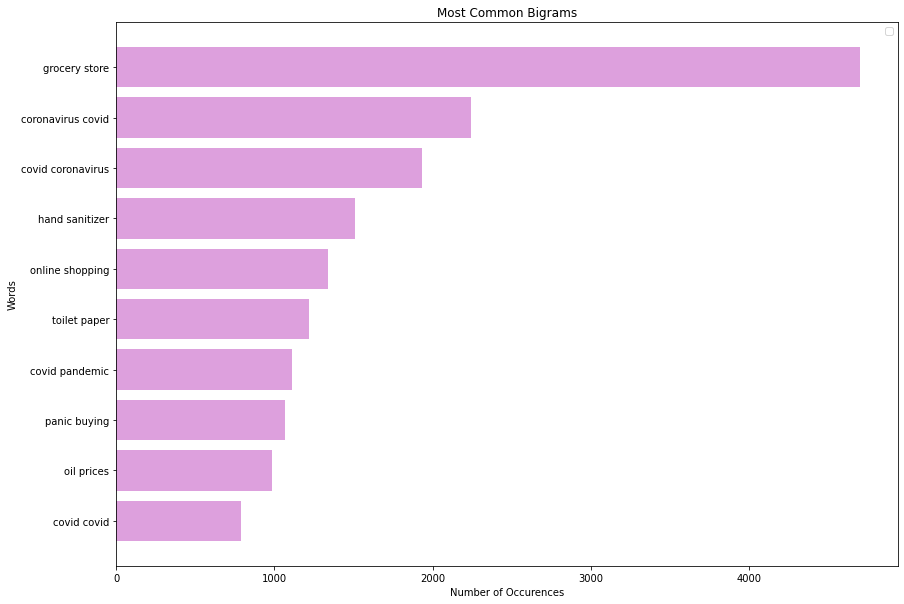

In [ ]:
all = bigram['bigrams']['Negative']+bigram['bigrams']['Extremely Negative']+bigram['bigrams']['Extremely Positive']+bigram['bigrams']['Positive']+bigram['bigrams']['Neutral']
bigram_most_common = all.most_common(10)
bigram_word, bigram_freq = zip(*bigram_most_common)
bigram_word = [' '.join(words) for words in bigram_word] 
print(bigram_word)
hfont = {'fontname':'Helvetica'}
plt.figure(figsize=[14, 10])
plt.barh(bigram_word, bigram_freq, color = 'plum')
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('Number of Occurences', **hfont)
plt.ylabel('Words', **hfont)
plt.title('Most Common Bigrams', **hfont)
plt.savefig('bigram_freq.png')
plt.show()

In [ ]:
train_set['trigrams']

0                        [(menyrbie, philgahan, chrisitv)]
1        [(advice, talk, neighbours), (talk, neighbours...
2        [(coronavirus, australia, woolworths), (austra...
3        [(food, stock, one), (stock, one, empty), (one...
4        [(ready, go, supermarket), (go, supermarket, c...
                               ...                        
41152    [(airline, pilots, offering), (pilots, offerin...
41153    [(response, complaint, provided), (complaint, ...
41154    [(know, getting, tough), (getting, tough, kame...
41155    [(wrong, smell, hand), (smell, hand, sanitizer...
41156    [(tartiicat, well, newused), (well, newused, r...
Name: trigrams, Length: 41157, dtype: object

## Feature Transformation

### Feature 1: Length of Tweet

In [ ]:
import numpy as np
def ConvertF1(data):
    X1 = np.zeros((len(data),1))
    for i in range(len(data)):
        words = data[i].split()
        X1[i] = len(words)
    return X1
X1_train = ConvertF1(train_set.CleanTweet)
X1_test = ConvertF1(test_set.CleanTweet)

In [ ]:
X1_train

array([[ 3.],
       [27.],
       [12.],
       ...,
       [13.],
       [ 9.],
       [25.]])

### Feature 2: Single, Bigram & Trigram: Count encoding

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=10)
X2_model = vectorizer.fit_transform(train_set.CleanTweet)
print(vectorizer.get_feature_names())
X2_train = X2_model.toarray() #add these to the Matrix

['abc', 'abcnews', 'ability', 'able', 'able buy', 'able find', 'able get', 'able go', 'able keep', 'able stock', 'able work', 'abroad', 'absence', 'absolute', 'absolutely', 'absurd', 'abt', 'abuja', 'abuse', 'abused', 'abusing', 'accc', 'accelerate', 'accelerated', 'accelerating', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'access food', 'access online', 'accessible', 'accessing', 'accommodation', 'according', 'account', 'accounts', 'accurate', 'accused', 'achieve', 'acknowledge', 'across', 'across america', 'across country', 'across globe', 'across nation', 'across state', 'across supermarket', 'across uk', 'across us', 'across world', 'act', 'act like', 'acted', 'acting', 'acting like', 'action', 'actions', 'active', 'actively', 'activities', 'activity', 'actors', 'acts', 'acts kindness', 'actual', 'actually', 'actually need', 'ad', 'adapt', 'adapt new', 'adapting', 'add', 'added', 'addiction', 'adding', 'addition', 'additional', 'additive', 'address', 'addressed', 'a

In [ ]:
len(X2_train[0])  #number of variables

12475

In [ ]:
X2_test = vectorizer.transform(test_set.CleanTweet)
X2_test

<3798x12475 sparse matrix of type '<class 'numpy.int64'>'
	with 75981 stored elements in Compressed Sparse Row format>

### Feature 3: Single, Bigram & Trigram: TF-IDF Encoding

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=10)
X3_model = vectorizer2.fit_transform(train_set.CleanTweet)
print(vectorizer2.get_feature_names())
X3_train = X3_model.toarray()

['abc', 'abcnews', 'ability', 'able', 'able buy', 'able find', 'able get', 'able go', 'able keep', 'able stock', 'able work', 'abroad', 'absence', 'absolute', 'absolutely', 'absurd', 'abt', 'abuja', 'abuse', 'abused', 'abusing', 'accc', 'accelerate', 'accelerated', 'accelerating', 'accept', 'acceptable', 'accepted', 'accepting', 'access', 'access food', 'access online', 'accessible', 'accessing', 'accommodation', 'according', 'account', 'accounts', 'accurate', 'accused', 'achieve', 'acknowledge', 'across', 'across america', 'across country', 'across globe', 'across nation', 'across state', 'across supermarket', 'across uk', 'across us', 'across world', 'act', 'act like', 'acted', 'acting', 'acting like', 'action', 'actions', 'active', 'actively', 'activities', 'activity', 'actors', 'acts', 'acts kindness', 'actual', 'actually', 'actually need', 'ad', 'adapt', 'adapt new', 'adapting', 'add', 'added', 'addiction', 'adding', 'addition', 'additional', 'additive', 'address', 'addressed', 'a

In [ ]:
len(X3_train[0])  #number of variables

12475

In [ ]:
X3_test = vectorizer2.transform(test_set.CleanTweet)
X3_test

<3798x11470 sparse matrix of type '<class 'numpy.float64'>'
	with 74066 stored elements in Compressed Sparse Row format>

In [ ]:
from scipy.sparse import csr_matrix
X3_test = csr_matrix(X3_test, dtype=np.float64).toarray()
X3_test

### Feature 4: Location: One hot Encoding

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
from geopy.exc import GeocoderTimedOut

def do_geocode(address):
    geopy = Nominatim(user_agent='sc2289@cornell.edu')
    try:
        return geopy.geocode(address, timeout=None)
    except GeocoderTimedOut:
        return do_geocode(address)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold 

# create dummy dataframe with 500 rows
features = np.random.randint(1, 100, 500)
labels = np.random.randint(1, 100, 500)
df = pd.DataFrame(data = {"X": features, "Y": labels})

kf = KFold(n_splits=10, random_state=42, shuffle=True) # Define the split - into 10 folds 
kf.get_n_splits(df) # returns the number of splitting iterations in the cross-validator
print(kf) 

for train_index, test_index in kf.split(df):
    X_train, X_test = df.loc[train_index, "X"], df.loc[test_index, "X"]
    y_train, y_test = df.loc[train_index, "Y"], df.loc[test_index, "Y"]

KFold(n_splits=10, random_state=42, shuffle=True)


In [ ]:
#loc = train_set['Location'].unique()

In [ ]:
geolocator = Nominatim(user_agent='sc2289@cornell.edu')
loc = train_set['Location'].unique()
d = dict(zip(loc, pd.Series(loc).apply(do_geocode).apply(lambda x: (x.latitude, x.longitude))))
train_set['coord'] = train_set['Location'].map(d)
train_set['coord']

### Feature 5: Tweet Date: One hot Encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
X5_train = enc.fit_transform((np.array(train_set.TweetAt)).reshape(-1,1))
enc.categories_

[array(['01-04-2020', '02-04-2020', '03-04-2020', '04-04-2020',
        '05-04-2020', '06-04-2020', '07-04-2020', '08-04-2020',
        '09-04-2020', '10-04-2020', '11-04-2020', '12-04-2020',
        '13-04-2020', '14-04-2020', '16-03-2020', '17-03-2020',
        '18-03-2020', '19-03-2020', '20-03-2020', '21-03-2020',
        '22-03-2020', '23-03-2020', '24-03-2020', '25-03-2020',
        '26-03-2020', '27-03-2020', '28-03-2020', '29-03-2020',
        '30-03-2020', '31-03-2020'], dtype=object)]

In [ ]:
k = enc.transform([['16-03-2020']]).toarray()

In [ ]:
X5_train

<41157x30 sparse matrix of type '<class 'numpy.float64'>'
	with 41157 stored elements in Compressed Sparse Row format>

In [ ]:
X5_test = enc.transform((np.array(test_set.TweetAt)).reshape(-1,1))

In [ ]:
X5_test

<3798x30 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

### Merge all the features into one frame

In [ ]:
X_train = np.concatenate((X1_train, X2_train),axis=1) #only used Feature 1 and 3 tentatively
X_train

array([[ 3.,  0.,  0., ...,  0.,  0.,  0.],
       [27.,  0.,  0., ...,  0.,  0.,  0.],
       [12.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  0., ...,  0.,  0.,  0.],
       [ 9.,  0.,  0., ...,  0.,  0.,  0.],
       [25.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
len(X_train[0]) #no. of features values

12476

In [ ]:
#X_test = np.concatenate((X1_test, X2_test),axis=1) #only used Feature 1 and 3 tentatively
#X_test

### Output Class: Sentiment: One hot encoding

In [ ]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(train_set.Sentiment)
lb.classes_

array(['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral',
       'Positive'], dtype='<U18')

In [ ]:
y_train = lb.transform(train_set.Sentiment)
y_test = lb.transform(test_set.Sentiment)

In [ ]:
#TO TRANSFORM BACK SUBSEQUENTLY
#lb.inverse_transform()

## Model Training

In [ ]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
y_train_array = le.fit_transform(train_set.Sentiment) 
y_test_array = le.fit_transform(test_set.Sentiment) 
y_train_array

array([3, 4, 4, ..., 4, 3, 2])

In [ ]:
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, KFold
  
classifier = MultinomialNB(); 
classifier.fit(X3_train, y_train_array) 
  
y_pred = classifier.predict(X3_test) 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

accuracy = accuracy_score(y_test_array, y_pred) 
f1 = f1_score(y_test_array, y_pred, average='micro') 
prec = precision_score(y_test_array, y_pred,average='micro') 
recall = recall_score(y_test_array, y_pred,average='micro') 
print(accuracy, f1, prec, recall) 

0.23091100579252238 0.23091100579252238 0.23091100579252238 0.23091100579252238
